# v1nyl

In [2]:
import os
import tensorflow as tf
import tensorflow.contrib.rnn as rnn
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import h5py as h5
import data_utils as du

/home/noodles/.conda/envs/turntable/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
def plot_time_step(slices):
	num_slice,_,_,_ = slices.shape
	print(num_slice)
	slices = slices.transpose(0,2,1,3)
#	slices = tf.transpose(slices, perm=[0,2,1,3])
#	print(slices.dtype)
	for s in range(num_slice):
		fig = plt.figure(s)
		# a = plt.subplot(num_slice, 1, 1+s)
		plt.imshow(np.abs(slices[s,:,:,0]), cmap='gray')
#		print(slices[s,:,:,0].dtype.base_dtype)
# 		plt.imshow(slices[s,:,:,0], cmap='gray')
#		plt.imshow(slices[s,:,:,0])
		plt.title("%d" % s)
	plt.show()

In [4]:
num_train, num_val, num_test = 70, 10, 20

train_data,val_data,test_data = du.create_dicts(num_train, num_val, num_test)
# maxX,maxY,maxT = du.init() # call once
# du.val_h5(val_data, maxX, maxY, maxT)
# du.test_h5(test_data, maxX, maxY, maxT)
# du.train_h5(train_data, maxX, maxY, maxT)

(80, 18, 224, 192, 1)
17


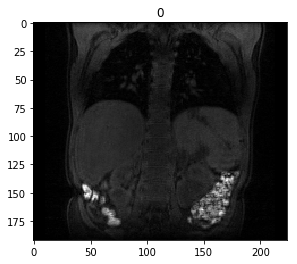

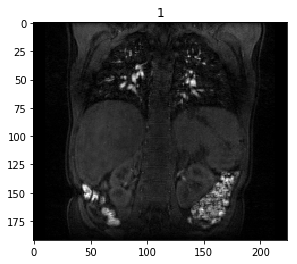

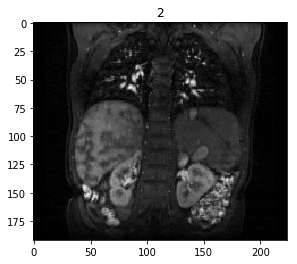

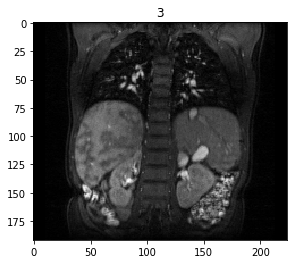

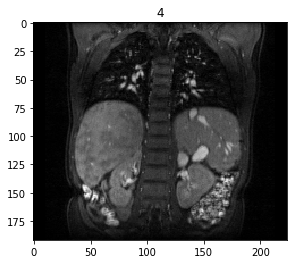

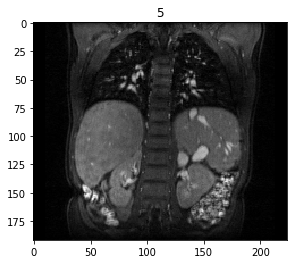

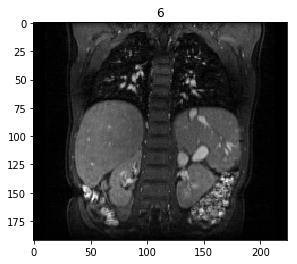

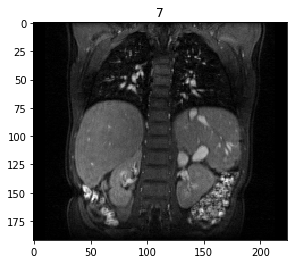

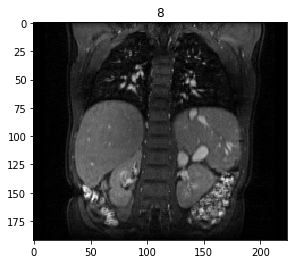

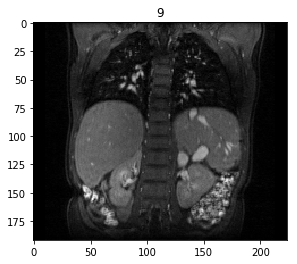

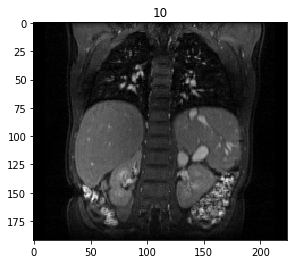

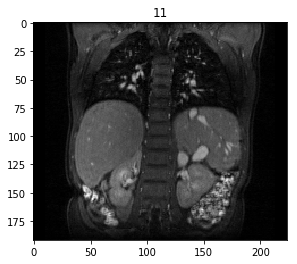

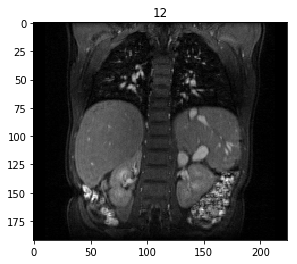

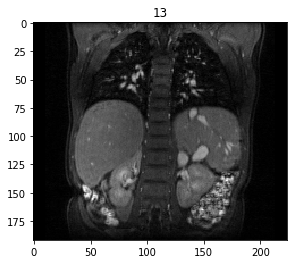

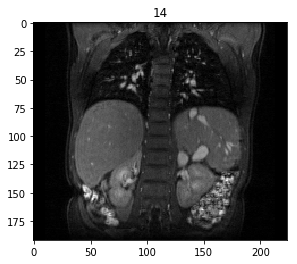

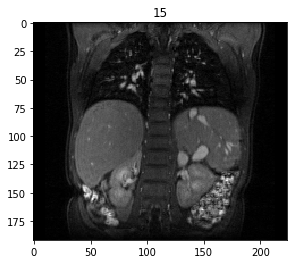

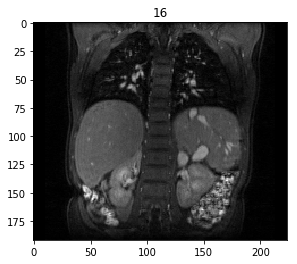

In [7]:
# fc = h5.File('datasets/train_curr.h5', 'r')
# fn = h5.File('datasets/train_next.h5', 'r')
# print(fc[train_data[0]].shape)
# print(fn[train_data[0]].shape)
# plot_time_step(fc[train_data[0]][510], fn[train_data[0]][510])
f = h5.File('datasets/train.h5', 'r')
print(f[train_data[0]].shape)
plot_time_step(f[train_data[0]][25,1:18,:,:,:])
f.close()

In [5]:
MODEL_NAME = 'model-001'

In [6]:
class ConvLSTMCell(tf.nn.rnn_cell.RNNCell):
  """A LSTM cell with convolutions instead of multiplications.
  Reference:
    Xingjian, S. H. I., et al. "Convolutional LSTM network: A machine learning approach for precipitation nowcasting." Advances in Neural Information Processing Systems. 2015.
  """

  def __init__(self, shape, filters, kernel, forget_bias=1.0, activation=tf.tanh, normalize=True, peephole=True, data_format='channels_last', reuse=None):
    super(ConvLSTMCell, self).__init__(_reuse=reuse)
    self._kernel = kernel
    self._filters = filters
    self._forget_bias = forget_bias
    self._activation = activation
    self._normalize = normalize
    self._peephole = peephole
    if data_format == 'channels_last':
        self._size = tf.TensorShape(shape + [self._filters])
        self._feature_axis = self._size.ndims
        self._data_format = None
    elif data_format == 'channels_first':
        self._size = tf.TensorShape([self._filters] + shape)
        self._feature_axis = 0
        self._data_format = 'NC'
    else:
        raise ValueError('Unknown data_format')

  @property
  def state_size(self):
    return tf.nn.rnn_cell.LSTMStateTuple(self._size, self._size)

  @property
  def output_size(self):
    return self._size

  def call(self, x, state):
    c, h = state

    x = tf.concat([x, h], axis=self._feature_axis)
    n = x.shape[-1].value
    m = 4 * self._filters if self._filters > 1 else 4
    W = tf.get_variable('kernel', self._kernel + [n, m])
    y = tf.nn.convolution(x, W, 'SAME', data_format=self._data_format)
    if not self._normalize:
      y += tf.get_variable('bias', [m], initializer=tf.zeros_initializer())
    j, i, f, o = tf.split(y, 4, axis=self._feature_axis)

    if self._peephole:
      i += tf.get_variable('W_ci', c.shape[1:]) * c
      f += tf.get_variable('W_cf', c.shape[1:]) * c

    if self._normalize:
      j = tf.contrib.layers.layer_norm(j)
      i = tf.contrib.layers.layer_norm(i)
      f = tf.contrib.layers.layer_norm(f)

    f = tf.sigmoid(f + self._forget_bias)
    i = tf.sigmoid(i)
    c = c * f + i * self._activation(j)

    if self._peephole:
      o += tf.get_variable('W_co', c.shape[1:]) * c

    if self._normalize:
      o = tf.contrib.layers.layer_norm(o)
      c = tf.contrib.layers.layer_norm(c)

    o = tf.sigmoid(o)
    h = o * self._activation(c)

    state = tf.nn.rnn_cell.LSTMStateTuple(c, h)

    return h, state

In [7]:
def model_fn(features,
             labels,
             mode,
             params):
    img_curr = features
    img_next = labels
    
    inputs = img_curr
    #print(inputs.get_shape())
    
    #inputs = tf.split(value=img_curr, num_or_size_splits=17)
    #print('inputs={}'.format(inputs))
    
    convlstm_cell = rnn.Conv2DLSTMCell(
        input_shape=[224, 192, 1],
        output_channels=1,
        kernel_shape=[5,5],
        use_bias=True,
        skip_connection=False,
        forget_bias=params.forget_bias
    )
    
    outputs, _ = tf.nn.dynamic_rnn(
        cell=convlstm_cell,
        inputs=inputs,
        dtype=tf.float32
    )
    
    print('outputs={}'.format(outputs))
    
    #plot_time_step(outputs[0,0:18])
    tf.summary.image('output', outputs[0,:,:,:,:], max_outputs=200)
    
    predictions = {'results': outputs}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        export_outputs = {
            'predictions': tf.estimator.export.PredictOutput(outputs)
        }
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=outputs
        )
    
    #print(outputs.get_shape())
    #print(img_next.get_shape())
    
    loss = tf.losses.mean_squared_error(img_next, outputs)
    
    optimizer = tf.train.AdamOptimizer(
        learning_rate=params.learning_rate,
        beta1=params.beta1,
        beta2=params.beta2,
        epsilon=params.epsilon
    )
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
    
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(img_next, outputs),
        "mae": tf.metrics.mean_absolute_error(img_next, outputs),
        "mae": tf.metrics.mean_absolute_error(img_next, outputs)
    }
    
    estimator_spec = tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops
    )
    
    return estimator_spec

In [8]:
print("Preparing dataset...")
ftr = h5.File('datasets/train.h5', 'r')
img = ftr[train_data[0]]
img_curr = np.absolute(img[:,:-1]).astype(np.float32)
max_curr = np.amax(img_curr, axis=(1,2,3))
img_curr = img_curr/max_curr[:,np.newaxis,np.newaxis,np.newaxis,:]
img_next = np.absolute(img[:,1:]).astype(np.float32)
max_next = np.amax(img_next, axis=(1,2,3))
img_next = img_next/max_next[:,np.newaxis,np.newaxis,np.newaxis,:]
dataset = tf.data.Dataset.from_tensor_slices((img_curr, img_next))
dataset = dataset.batch(1)

Preparing dataset...


In [9]:
def main(_):
    tf.logging.set_verbosity(tf.logging.INFO)

#    print("Preparing dataset...")
#    ftr = h5.File('datasets/train.h5', 'r')
#    img = ftr[train_data[0]]
#    img_curr = np.absolute(img[:,:-1]).astype(np.float32)
#    img_next = np.absolute(img[:,1:]).astype(np.float32)
#    dataset = tf.data.Dataset.from_tensor_slices((img_curr, img_next))
#    dataset = dataset.batch(1)

    hparams = tf.contrib.training.HParams(
        num_epochs=1,
        #batch_size = 80,
        forget_bias=1.0,
        learning_rate=0.001,
        beta1=0.9,
        beta2=0.999,
        epsilon=1
    )
    
    run_config = tf.estimator.RunConfig(
        log_step_count_steps=2,
        save_summary_steps=6,
        tf_random_seed=19830610,
        model_dir=os.path.join('summary', 'train')
    )
    
    estimator = tf.estimator.Estimator(
        model_fn=model_fn, params=hparams, config=run_config)
    
    def input_fn():
        train_iterator = dataset.make_one_shot_iterator()
        features, labels = train_iterator.get_next()
        return features, labels
    
    estimator.train(input_fn=input_fn, max_steps=None)

In [10]:
if __name__ == '__main__':
    tf.app.run()

INFO:tensorflow:Using config: {'_model_dir': 'summary/train', '_tf_random_seed': 19830610, '_save_summary_steps': 6, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 2, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff41c96cb38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
outputs=Tensor("rnn/transpose_1:0", shape=(?, 17, 224, 192, 1), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into summary/train/model.ckpt.
INFO:tensorflow:loss

SystemExit: 

/home/noodles/.conda/envs/turntable/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%tb